# District heating network design and simulation from scratch

Create a district heating network from OpenStreetMap data,
and perform a DHS Investment Optimisation.
Based on the routing and dimensioning of the optimisation, a pandapipes
model is generated for the detailed thermo-hydraulic calculation for
checking the feasibility of the suggested design of the optimisation.

Overview:

## Part I: Optimisation of routing with DHNx


### Get and prepare the input data for the optimisation
#### a) Geometry of potential routes and buildings
- Get OSM data
- Process the geometry for DHNx
#### b) Pre-calculate the hydraulic parameter

### Perform the Optimisation
#### a) Initialise the ThermalNetwork and check input
#### b) Perform the optimisation
#### c) Process and plot the results

### Part II: Simulation with pandapipes
- Define the pandapipes parameters
- Prepare the component tables of the DHNx network
- Create the pandapipes model
- Execute the pandapipes simulation
- Example of exports of the results
- Plot the results of pandapipes simulation

Requirements:

- dhnx (0.0.4@dev, 0.5.0 >= oemof.solph < 0.6.0) with extra_requires (osmnx, geopandas, CoolProp)
- pandapipes
- Make sure you have the solver CBC installed (via conda!!)

Contributors:

- Joris Zimmermann
- Johannes Röder

In [1]:
import logging
import math

from CoolProp.CoolProp import PropsSI
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from oemof.tools import logger
import osmnx as ox
import pandas as pd
import pandapipes as pp
from shapely import geometry

from dhnx.network import ThermalNetwork
from dhnx.input_output import load_invest_options
from dhnx.gistools.connect_points import process_geometry
from dhnx.optimization.precalc_hydraulic import v_max_bisection,\
    calc_mass_flow, calc_power, calc_pipe_loss

logger.define_logging(
    screen_level=logging.INFO,
    logfile="dhnx.log"
)

15:10:28-INFO-Path for logging: C:\Users\carl\.oemof\log_files\dhnx.log


'C:\\Users\\carl\\.oemof\\log_files\\dhnx.log'

# **Part I: Optimisation of routing with DHNx**

# Get and prepare the input data for the optimisation

## a) Geometry of potential routes and buildings

### Get OSM data

If you do not have any geo-referenced data, you can obtain the footprints
and the street network as potential routes for the DHS from OpenStreetMaps.
This is done with the library osmnx.

Alternatively, you can of course use your individual GIS data.
With geopandas, you can easily import different formats as .shp, .geojson
or other GIS formats.
The workflow could also use the OSM data as starting point,
then you could manually edit the geometries, e.g. in QGIS,
and the import them again in your Python script with geopandas.

We set use_cache of osmnx it False to avoid cache in the repository

In [2]:
ox.settings.use_cache = False

For getting the OSM data, first, define a bounding box polygon from a list
of lat/lon coordinates, that contains the district you are considering.

In [3]:
bbox = [
    (9.121146, 54.190682),
    (9.119905, 54.192672),
    (9.115752, 54.191913),
    (9.117364, 54.189318),
]

polygon = geometry.Polygon(bbox)

With osmnx we can convert create a graph from the street network and
plot this with the plotting function of osmnx

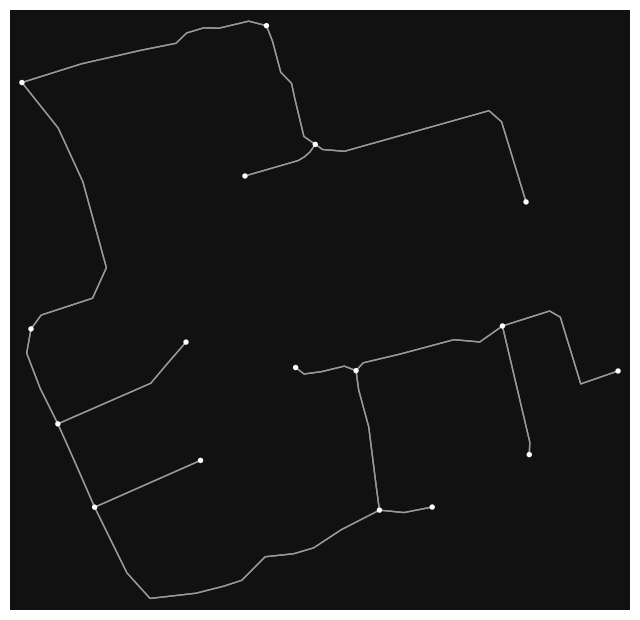

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
graph = ox.graph_from_polygon(polygon, network_type='drive_service')
ox.plot_graph(graph)

Next, we create geopandas dataframes with the footprints of the buildings
(polygon geometries) and also for the street network, which are line
geometries.

In [5]:
gdf_poly_houses = ox.features_from_polygon(polygon, tags={'building': True})
gdf_lines_streets = ox.features_from_polygon(polygon, tags={'highway': True})

Note: you could also use only specific types of buildings and streets
Therefore, select the street types you want to consider as routes for the district heating network. 
see also: https://wiki.openstreetmap.org/wiki/Key:highway

In [6]:
streets = dict({
    'highway': [
        'residential',
        'service',
        'unclassified',
    ]
})

And also select the building types you want to import
see: https://wiki.openstreetmap.org/wiki/Key:building

In [7]:
buildings = dict({
    'building': [
        'apartments',
        'commercial',
        'detached',
        'house',
        'industrial',
        'residential',
        'retail',
        'semidetached_house'
    ]
})

We need to make sure that only polygon geometries are used for the houses

In [8]:
gdf_poly_houses = gdf_poly_houses[gdf_poly_houses['geometry'].apply(
    lambda x: isinstance(x, geometry.Polygon)
)]

We need to make sure that only polygon geometries are used for the houses and that only line geometries are used for the streets

In [9]:
gdf_poly_houses = gdf_poly_houses[gdf_poly_houses['geometry'].apply(
    lambda x: isinstance(x, geometry.Polygon)
)]

gdf_lines_streets = gdf_lines_streets[gdf_lines_streets['geometry'].apply(
    lambda x: isinstance(x, geometry.LineString)
)]

Further, we filter the houses for houses with address to remove e.g. carports

In [10]:
gdf_poly_houses.dropna(subset="addr:housenumber", inplace=True)

Remove nodes column (that make somehow trouble for exporting .geojson)

In [11]:
if "nodes" in gdf_poly_houses.columns:
    gdf_poly_houses.drop(columns=['nodes'], inplace=True)
if "nodes" in gdf_lines_streets.columns:
    gdf_lines_streets.drop(columns=['nodes'], inplace=True)

We need one (or more) buildings that we call "generators", that represent the heat supply facility. In this example, we randomly choose one of the buildings and put it to a new GeoDataFrame. Of course, in your project, you need to import a geopandas DataFrame with you heat supply sites.

In [12]:
np.random.seed(7)
id_generator = np.random.randint(len(gdf_poly_houses))
gdf_poly_gen = gdf_poly_houses.iloc[[id_generator]].copy()
gdf_poly_houses.drop(index=gdf_poly_houses.index[id_generator], inplace=True)

The houses need a maximum thermal power. For this example, we set it to a random value between 10 and 50 kW for all houses.
Note: You can also provide the heat demand as demand time series.

In [13]:
gdf_poly_houses['P_heat_max'] = \
    np.random.randint(10, 50, size=len(gdf_poly_houses))

Now, let's plot the given geometry with matplotlib

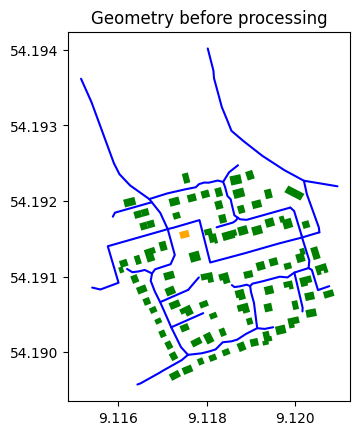

In [14]:
fig, ax = plt.subplots()
gdf_lines_streets.plot(ax=ax, color='blue')
gdf_poly_gen.plot(ax=ax, color='orange')
gdf_poly_houses.plot(ax=ax, color='green')
plt.title('Geometry before processing')
plt.show()

### Process the geometry for DHNx

Note: if you use your individual geometry layers, you must make sure, that the geometries of the lines are line geometries. And the geometries of the buildings and generators are either polygon or point geometries.

if you are using your individual geometries, load your geopandas DataFrames:

gdf_lines_streets = gpd.read_file('your_file.geojson')
gdf_poly_gen = gpd.read_file('your_file.geojson')
gdf_poly_houses = gpd.read_file('your_file.geojson')

The next step is the processing of the geometries with DHNx. This function connects the consumers and producers to the line network by creating the connection lines to the buildings, and sets IDs for each building/segment.
For connecting the polygons (in case you have polygons) to the street network, you can choose between two methods: connect to the midpoint of the polygon, or to the boundary of the polygon.

In [15]:
tn_input = process_geometry(
    lines=gdf_lines_streets,
    producers=gdf_poly_gen,
    consumers=gdf_poly_houses,
    method="boundary",  # select the method of how to connect the buildings
)

15:10:31-INFO-CRS of GeoDataFrame converted to EPSG:4647
15:10:31-INFO-CRS of GeoDataFrame converted to EPSG:4647
15:10:31-INFO-CRS of GeoDataFrame converted to EPSG:4647
15:10:32-INFO-Run "boundary" method for finding the building connections
15:10:32-INFO-Run "boundary" method for finding the building connections
15:10:32-INFO-Welding lines... reduced from 176 to 114 lines
15:10:33-INFO-Welding lines... reduced from 114 to 103 lines
15:10:33-INFO-Welding lines... reduced from 103 to 99 lines
15:10:33-INFO-Welding lines... reduced from 99 to 97 lines
15:10:34-INFO-Welding lines... done
15:10:34-INFO-Total line length is 2378 m
15:10:34-INFO-Check passed: No points with a distance closer than 0.001


The result of the processing are a dictionary with four geoDataFrames:
consumers, producers, pipes and forks.
After successfully processing, we can plot the geometry after processing.

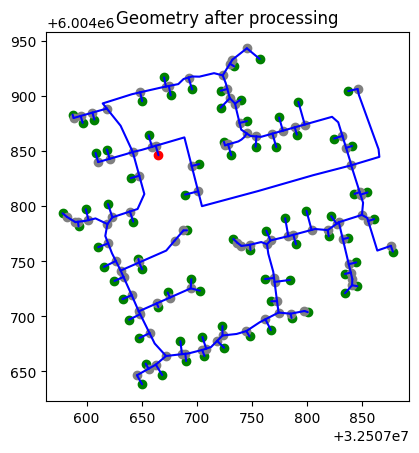

In [16]:
_, ax = plt.subplots()
tn_input['consumers'].plot(ax=ax, color='green')
tn_input['producers'].plot(ax=ax, color='red')
tn_input['pipes'].plot(ax=ax, color='blue')
tn_input['forks'].plot(ax=ax, color='grey')
plt.title('Geometry after processing')
plt.show()

## b) Pre-calculate the hydraulic parameter

Besides the geometries, we need the techno-economic data for the investment optimisation of the DHS piping network. Therefore, we load the pipes data table. This is the information you need from your manufacturer / from your project.

In [17]:
df_pipe_data = pd.read_csv("input/Pipe_data.csv", sep=",")
print(df_pipe_data.head(n=8))

   DN number  Inner diameter [m]  Roughness [mm]  U-value [W/mK]  \
0         20              0.0216           0.045          0.1110   
1         25              0.0285           0.045          0.1311   
2         32              0.0372           0.045          0.1424   
3         40              0.0431           0.045          0.1606   
4         50              0.0545           0.045          0.1794   
5         65              0.0703           0.045          0.2009   
6         80              0.0825           0.045          0.2105   
7        100              0.1071           0.045          0.2193   

   alpha [W/m2K]  Costs [eur]  
0       1.635759          600  
1       1.464225          640  
2       1.218477          670  
3       1.186092          710  
4       1.047794          760  
5       0.909651          850  
6       0.812172          940  
7       0.651777         1070  


This is an example of input data. The Roughness refers to the roughness of the inner surface and depends on the material (steel, plastic). The U-value and the costs refer to the costs of the whole pipeline trench, so including forward and return pipelines. The design process of DHNx is based on a maximum pressure drop per meter as design criteria:

In [18]:
df_pipe_data["Maximum pressure drop [Pa/m]"] = 150

You could also define the maximum pressure drop individually for each DN number.

As further assumptions, you need to estimate the operation temperatures of the district heating network in the design case:

In [19]:
df_pipe_data["T_forward [C]"] = 80
df_pipe_data["T_return [C]"] = 50
df_pipe_data["T_level [C]"] = 65

Based on that pressure drop, the maximum transport capacity (mass flow) is calculated for each DN number.

First, the maximum flow velocity is calculated:

In [20]:
df_pipe_data["v_max [m/s]"] = df_pipe_data.apply(lambda row: v_max_bisection(
    d_i=row["Inner diameter [m]"],
    T_average=row["T_level [C]"],
    k=row['Roughness [mm]'],
    p_max=row["Maximum pressure drop [Pa/m]"]), axis=1)

15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35-INFO-Maximum flow velocity calculated. Iterations: 15, Flow velocity: 0.5127 [m/s], Pressure drop: 150.0218 [Pa/m]
15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35-INFO-Maximum flow velocity calculated. Iterations: 15, Flow velocity: 0.6249 [m/s], Pressure drop: 149.9876 [Pa/m]
15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35-INFO-Maximum flow velocity calculated. Iterations: 13, Flow velocity: 0.6868 [m/s], Pressure drop: 150.0803 [Pa/m]
15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35-INFO-Maximum flow velocity calculated. Iterations: 14, Flow velocity: 0.7569 [m/s], Pressure drop: 149.9497 [Pa/m]
15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35-INFO-Maximum flow velocity calculated. Iterations: 11, Flow velocity: 0.8831 [m/s], Pressure drop: 149.9561 [Pa/m]
15:10:35-INFO-Bi-section method: p_epsilon criterion reached.
15:10:35

Then, the maximum mass flow:

In [21]:
df_pipe_data['Mass flow [kg/s]'] = df_pipe_data.apply(
    lambda row: calc_mass_flow(
        v=row['v_max [m/s]'],
        di=row["Inner diameter [m]"],
        T_av=row["T_level [C]"]), axis=1,
)

Finally, the maximum thermal transport capacity of each DN pipeline trench in kW is calculated based on the design temperatures of the DHS:

In [22]:
df_pipe_data['P_max [kW]'] = df_pipe_data.apply(
    lambda row: 0.001 * calc_power(
        T_vl=row['T_forward [C]'],
        T_rl=row['T_return [C]'],
        mf=row['Mass flow [kg/s]']), axis=1,
)

Furthermore, the thermal loss of ech DN number per meter is calculated (based on the design temperatures of the district heating network):

In [23]:
temperature_ground = 10

df_pipe_data['P_loss [kW]'] = df_pipe_data.apply(
    lambda row: 0.001 * calc_pipe_loss(
        temp_average=row["T_level [C]"],
        u_value=row["U-value [W/mK]"],
        temp_ground=temperature_ground,
    ), axis=1,
)

The last step is the linearisation of the cost  and loss parameter for the DHNx optimisation (which is based on the MILP optimisation package oemof-solph)

It is possible to use different accuracies: you could linearize the cost and loss values with 1 segment, or many segment, or you can also perform an optimisation with discrete DN numbers (which is of course computationally more expensive). See also the DHNx example "discrete_DN_numbers"

Here follows a linear approximation with 1 segment:

In [24]:
constants_costs = np.polyfit(
    df_pipe_data['P_max [kW]'], df_pipe_data['Costs [eur]'], 1,
)
constants_loss = np.polyfit(
    df_pipe_data['P_max [kW]'], df_pipe_data['P_loss [kW]'], 1,
)

print('Costs constants: ', constants_costs)
print('Loss constants: ', constants_loss)

Costs constants:  [8.18589953e-02 8.18003571e+02]
Loss constants:  [4.03553566e-07 1.00584507e-02]


Let's plot the economic assumptions:

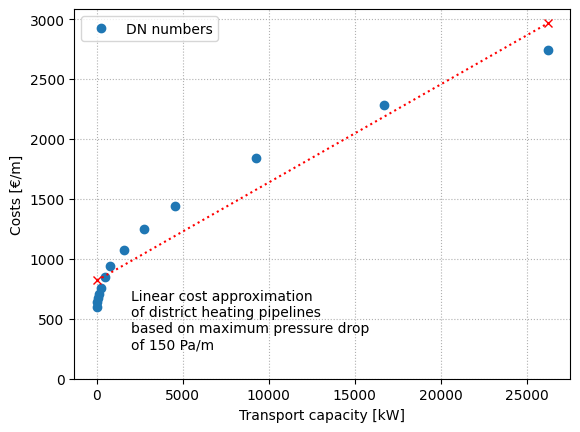

In [25]:
x_min = df_pipe_data['P_max [kW]'].min()
x_max = df_pipe_data['P_max [kW]'].max()
y_min = constants_costs[0] * x_min + constants_costs[1]
y_max = constants_costs[0] * x_max + constants_costs[1]

_, ax = plt.subplots()
x = df_pipe_data['P_max [kW]']
y = df_pipe_data['Costs [eur]']
ax.plot(x, y, lw=0, marker="o", label="DN numbers",)
ax.plot(
    [x_min, x_max], [y_min, y_max],
    ls=":", color='r', marker="x"
)
ax.set_xlabel("Transport capacity [kW]")
ax.set_ylabel("Costs [€/m]")
plt.text(
    2000, 250,
    "Linear cost approximation \n"
    "of district heating pipelines \n"
    "based on maximum pressure drop \n"
    "of {:.0f} Pa/m".format(df_pipe_data["Maximum pressure drop [Pa/m]"][0])
)
plt.legend()
plt.ylim(0, None)
plt.grid(ls=":")
plt.show()

The next step is the creation of the input dataframe with the techno-economic parameter of the district heating pipelines (See DHNx documentation).

Note: you can also skip the previous pre-calculation of the hydraulic parameter and directly fill the following table with the optimisation parameter of the district heating pipelines.

In [26]:
df_pipes = pd.DataFrame(
    {
        "label_3": "your-pipe-type-label",
        "active": 1,
        "nonconvex": 1,
        "l_factor": constants_loss[0],
        "l_factor_fix": constants_loss[1],
        "cap_max": df_pipe_data['P_max [kW]'].max(),
        "cap_min": df_pipe_data['P_max [kW]'].min(),
        "capex_pipes": constants_costs[0],
        "fix_costs": constants_costs[1],
    }, index=[0],
)

Export the optimisation parameter of the dhs pipelines to the investment data and replace the default csv file.

You can also directly change the parameters of the pipes.csv file, instead of using the pre-calculation shown above.

In [27]:
df_pipes.to_csv(
    "invest_data/network/pipes.csv", index=False,
)

# Perform the Optimisation

## a) Initialise the ThermalNetwork and check input

In [28]:
network = ThermalNetwork()

Add the pipes, forks, consumer, and producers as components to the ThermalNetwork:

In [29]:
for k, v in tn_input.items():
    network.components[k] = v

Check if ThermalNetwork is consistent:

In [30]:
network.is_consistent()

True

Important: Check if geometry is connected with networknx. It sometimes happens that two lines in your input geometry are not connected, because the starting point of one line is not exactly the ending point of the other line.

In [31]:
network.nx_graph = network.to_nx_undirected_graph()
g = network.nx_graph
nx.is_connected(g)

True

If `nx.is_connected(g)` returns false, you can use the following lines to find out of how many networks your geometry consists, and which ids belong to these networks. With this information, load your geometry in QGIS and manually fix the geometry.

In [32]:
# Number of networks
print(len(sorted(nx.connected_components(g), key=len, reverse=True)))

# Components of the network
print([c for c in sorted(nx.connected_components(g), key=len, reverse=True)])

1
[{'consumers-70', 'forks-21', 'consumers-54', 'forks-86', 'forks-32', 'forks-82', 'consumers-69', 'consumers-17', 'forks-14', 'forks-37', 'forks-28', 'consumers-63', 'consumers-77', 'consumers-53', 'consumers-9', 'forks-27', 'forks-62', 'forks-38', 'forks-26', 'consumers-5', 'consumers-34', 'forks-20', 'forks-36', 'forks-87', 'consumers-67', 'forks-46', 'consumers-48', 'consumers-3', 'forks-90', 'consumers-65', 'consumers-33', 'consumers-64', 'forks-47', 'forks-43', 'consumers-38', 'consumers-79', 'forks-23', 'consumers-22', 'consumers-68', 'forks-11', 'forks-12', 'consumers-23', 'consumers-32', 'forks-63', 'forks-67', 'forks-39', 'consumers-78', 'forks-15', 'consumers-75', 'forks-92', 'forks-88', 'forks-40', 'consumers-66', 'consumers-51', 'forks-61', 'forks-68', 'forks-66', 'forks-17', 'forks-85', 'forks-58', 'forks-65', 'forks-33', 'forks-6', 'forks-78', 'forks-75', 'forks-72', 'forks-18', 'consumers-76', 'consumers-49', 'forks-10', 'forks-80', 'forks-51', 'forks-44', 'consumers-1

Now, we have all data collected and checked, and we continue with the DHNx investment optimisation

Now, we load the whole specification for the oemof-solph components from the invest_data folder, in which we previously exported the specifications for the dhs pipelines:

In [33]:
invest_opt = load_invest_options('invest_data')

With the optimisation settings, you can e.g. configure the solver. Especially increasing the solution tolerance with 'ratioGap' or setting a maximum runtime in 'seconds' helps if large networks take too long to solve.
Please see :func::dhnx.optimisation_models.setup_optimise_investment: for all options.

In [34]:
settings = dict(solver='cbc',
                solve_kw={
                    'tee': True,  # print solver output
                },
                solver_cmdline_options={
                    # 'allowableGap': 1e-5,  # (absolute gap) default: 1e-10
                    # 'ratioGap': 0.2,  # (0.2 = 20% gap) default: 0
                    # 'seconds': 60 * 1,  # (maximum runtime) default: 1e+100
                },
                # bidirectional_pipes=True,
                )

## b) Perform the optimisation

Now, we execute the actual optimisation:

In [35]:
network.optimize_investment(invest_options=invest_opt, **settings)

15:10:36-INFO-Initialize the energy system
15:10:36-INFO-Create oemof objects
15:10:36-INFO-Producers, Consumers Nodes appended.
15:10:36-INFO-DHS Nodes appended.
15:10:36-INFO-Energysystem has been created
15:10:36-INFO-Build the operational model


C:\Users\carl\miniconda3\envs\pandapipes\Lib\site-packages\oemof\solph\flows\_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
C:\Users\carl\miniconda3\envs\pandapipes\Lib\site-packages\oemof\network\network\nodes.py:126: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(


15:10:36-INFO-Solve the optimization problem
Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Mar  5 2025 

command line - C:\Users\carl\miniconda3\envs\pandapipes\Library\bin\cbc.exe -printingOptions all -import C:\Users\carl\AppData\Local\Temp\tmpoo6zxx3n.pyomo.lp -stat=1 -solve -solu C:\Users\carl\AppData\Local\Temp\tmpoo6zxx3n.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 1078 (-1574) rows, 753 (-1448) columns and 3122 (-2929) elements
Statistics for presolved model
Original problem has 275 integers (275 of which binary)
Presolved problem has 275 integers (275 of which binary)
==== 203 zero objective 357 different
==== absolute objective values 357 different
==== for integers 0 zero objective 178 different
==== for integers absolute objective values 178 different
===== end objective counts


Problem has 1078 rows, 753 columns (550 with objective) and 3122 elements
Column breakdown:
203 of type 0.0->inf, 195 of type 0.0->

## c) Process and plot the results

In [36]:
results_edges = network.results.optimization['components']['pipes']
# print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
#                      'direction', 'costs', 'losses']])

print(results_edges[['costs']].sum())
print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

costs    1.835421e+06
dtype: float64
Objective value:  1835420.876134149


(The costs of the objective value and the investment costs of the DHS pipelines are the same, since no additional costs (e.g. for energy sources) are considered in this example.)

add the investment results to the geoDataFrame of the pipes:

In [37]:
gdf_pipes = network.components['pipes']
gdf_pipes.drop("hp_type", axis=1, inplace=True)
gdf_pipes = gdf_pipes.join(
    results_edges[["hp_type", "capacity", "direction", "costs", "losses"]],
    rsuffix='',
)

plot output after processing the geometry:

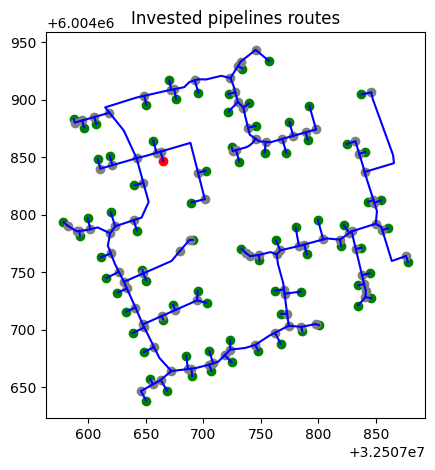

In [38]:
_, ax = plt.subplots()
network.components['consumers'].plot(ax=ax, color='green')
network.components['producers'].plot(ax=ax, color='red')
network.components['forks'].plot(ax=ax, color='grey')
gdf_pipes[gdf_pipes['capacity'] > 0.01].plot(ax=ax, color='blue')
plt.title('Invested pipelines routes')
plt.tight_layout()
plt.show()

Round the results to the next upper existing DN number You can use the following functions or write your own, if e.g. you do not want to select the next upper DN number but round to the next DN number.

In [39]:
def get_dn(capa, table):

    if capa > 0.01:

        if capa > table["P_max [kW]"].max():
            index = table.sort_values(by=["P_max [kW]"],
                                      ascending=False).index[0]
            dn = table.loc[index, "Bezeichnung [DN]"]
            print('Maximum heat demand exceeds capacity of biggest pipe! The '
                  'biggest pipe type is selected.')
        else:
            index = table[table["P_max [kW]"] >= capa].sort_values(
                by=["P_max [kW]"]).index[0]
            dn = table.loc[index, "DN number"]
    else:
        dn = 0

    return dn


def get_dn_apply(df, table):
    df['DN'] = df.apply(lambda x: get_dn(x['capacity'], table), axis=1)
    return df


def get_real_costs(df, table):

    def get_specific_costs(size):

        if size > 0.01:
            i = table.loc[table["DN number"] == size].index[0]
            costs = table.at[i, "Costs [eur]"]
        else:
            costs = 0

        return costs

    if 'DN' not in df.columns:
        ValueError("The 'DN' column is missing!")

    df['DN_costs [€]'] = df.apply(
        lambda x: x['length'] * get_specific_costs(x['DN']), axis=1)

    return df


def get_dn_and_costs(df, table):
    df = get_dn_apply(df, table)
    df = get_real_costs(df, table)
    return df


def get_dn_loss(df, table):

    table.rename(columns={"DN number": "DN"}, inplace=True)
    df = df.join(table[['DN', 'P_loss [kW]']].set_index('DN'), on='DN')
    df['DN_loss [kW]'] = df['P_loss [kW]'] * df['length']

    return df


gdf_pipes = get_dn_and_costs(gdf_pipes, df_pipe_data)
gdf_pipes = get_dn_loss(gdf_pipes, df_pipe_data)

Plot the results with the DN numbers:

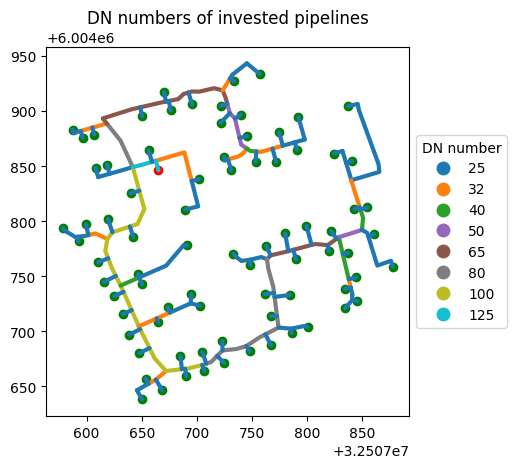

In [40]:
_, ax = plt.subplots()
network.components['consumers'].plot(ax=ax, color='green')
network.components['producers'].plot(ax=ax, color='red')
# network.components['forks'].plot(ax=ax, color='grey')
gdf_pipes[gdf_pipes['capacity'] > 0].plot(
    ax=ax, lw=3,
    column='DN', categorical=True, legend=True,
    legend_kwds={'loc': 'center left', "title": "DN number",
                 'bbox_to_anchor': (1, 0.5), 'fmt': "{:.0f}"}
)
plt.title('DN numbers of invested pipelines')
plt.show()

## Part II: Simulation with pandapipes

Define the pandapipes parameters:

In [41]:
dT = 30  # [K]

pi = math.pi  # [-]
v = 1.0  # [m/s] (Initial value for simulation?)

pressure_net = 12  # [bar] (Pressure at the heat supply)
pressure_pn = 20
feed_temp = 348  # 75 °C (Feed-in temperature at the heat supply)
ext_temp = 283  # 10 °C (temperature of the ground)

p = pressure_net * 100000  # pressure in [Pa]

cp = PropsSI('C', 'T', feed_temp, 'P', p, 'IF97::Water') * 0.001  # [kJ/(kg K)]
d = PropsSI('D', 'T', feed_temp, 'P', p, 'IF97::Water')  # [kg/m³]

Prepare the component tables of the DHNx network:

In [42]:
forks = network.components['forks']
consumers = network.components['consumers']
producers = network.components['producers']
pipes = gdf_pipes

calculate massflow for each consumer and producer:

In [43]:
consumers['massflow'] = consumers['P_heat_max'].apply(lambda x: x / (cp * dT))

delete pipes with capacity of 0:

In [44]:
pipes = pipes.drop(pipes[pipes['capacity'] == 0].index)

reset the index to later on merge the pandapipes results, that do not know an 'id' or 'name' anymore:

In [45]:
pipes = pipes.reset_index()

add the data of technical data sheet with the DN numbers to the pipes table:

In [46]:
pipes = pipes.join(df_pipe_data[[
    "DN", "Inner diameter [m]", "Roughness [mm]", "U-value [W/mK]",
    "alpha [W/m2K]",
]].set_index('DN'), on='DN')

# Create the pandapipes model

Now, we create the pandapipes network (pp_net). Note that we only model the forward pipeline system in this example and focus on the pressure losses due to the pipes (no pressure losses e.g. due to expansion bend and so on). However, if we assume the same pressure drop for the return pipes and add a constant value for the substation, we can a first idea of the hydraulic feasibility of the drafted piping system, and we can check, if the temperature at the consumers is sufficiently high.

In [47]:
pp_net = pp.create_empty_network(fluid="water")

for index, fork in forks.iterrows():
    pp.create_junction(
        pp_net, pn_bar=pressure_pn, tfluid_k=feed_temp,
        name=fork['id_full']
    )

for index, consumer in consumers.iterrows():
    pp.create_junction(
        pp_net, pn_bar=pressure_pn, tfluid_k=feed_temp,
        name=consumer['id_full']
    )

for index, producer in producers.iterrows():
    pp.create_junction(
        pp_net, pn_bar=pressure_pn, tfluid_k=feed_temp,
        name=producer['id_full']
    )

create sink for consumers:

In [48]:
for index, consumer in consumers.iterrows():
    pp.create_sink(
        pp_net,
        junction=pp_net.junction.index[
            pp_net.junction['name'] == consumer['id_full']][0],
        mdot_kg_per_s=consumer['massflow'],
        name=consumer['id_full']
    )

create source for producers:

In [49]:
for index, producer in producers.iterrows():
    pp.create_source(
        pp_net,
        junction=pp_net.junction.index[
            pp_net.junction['name'] == producer['id_full']][0],
        mdot_kg_per_s=consumers['massflow'].sum(),
        name=producer['id_full']
    )

EXTRENAL GRID as slip (Schlupf):

In [50]:
for index, producer in producers.iterrows():
    pp.create_ext_grid(
        pp_net,
        junction=pp_net.junction.index[
            pp_net.junction['name'] == producer['id_full']][0],
        p_bar=pressure_net,
        t_k=feed_temp,
        name=producer['id_full'],
    )

create pipes:

In [51]:
for index, pipe in pipes.iterrows():
    pp.create_pipe_from_parameters(
        pp_net,
        from_junction=pp_net.junction.index[
            pp_net.junction['name'] == pipe['from_node']][0],
        to_junction=pp_net.junction.index[
            pp_net.junction['name'] == pipe['to_node']][0],
        length_km=pipe['length'] / 1000,  # convert to km
        diameter_m=pipe["Inner diameter [m]"],
        k_mm=pipe["Roughness [mm]"],
        alpha_w_per_m2k=pipe["alpha [W/m2K]"],
        text_k=ext_temp,
        name=pipe['id'],
    )

# Execute the pandapipes simulation

In [52]:
pp.pipeflow(
    pp_net, stop_condition="tol", iter=3, friction_model="colebrook",
    mode="sequential", transient=False, nonlinear_method="automatic", tol_p=1e-3,
    tol_v=1e-3,
)

print(pp_net.res_junction.head(n=8))
print(pp_net.res_pipe.head(n=8))

       p_bar         t_k
0  11.792263  347.756392
1  11.798203  347.836653
2  11.890835  347.826934
3  11.897704  347.873226
4  11.799719  347.857153
5  11.815776  347.908386
6  11.906491  347.919548
7  11.839514  347.968830
   v_mean_m_per_s  p_from_bar   p_to_bar    t_from_k      t_to_k  t_outlet_k  \
0       -0.371019   11.792263  11.798203  347.756392  347.836653  347.756392   
1       -0.473385   11.890835  11.897704  347.826934  347.873226  347.826934   
2       -0.371031   11.798203  11.799719  347.836653  347.857153  347.836653   
3       -0.614133   11.799719  11.815776  347.857153  347.908386  347.857153   
4       -0.495647   11.897704  11.906491  347.873226  347.919548  347.873226   
5       -0.638349   11.815776  11.839514  347.908386  347.968830  347.908386   
6       -0.690920   11.906491  11.926739  347.919548  347.960569  347.919548   
7       -0.191901   11.943597  11.945693  347.659223  347.842218  347.659223   

   mdot_from_kg_per_s  mdot_to_kg_per_s  vdot_m3_per_s

merge results to pipes GeoDataFrame:

In [53]:
pipes = pd.merge(
    pipes, pp_net.res_pipe, left_index=True, right_index=True,
    how='left'
)

# Example of exports of the results to excel

In [54]:
#with pd.ExcelWriter('results/results_fine.xlsx') as writer:
#     pipes.to_excel(
#         writer, sheet_name='pipes',
#         columns=['id', 'type', 'from_node', 'to_node', 'length', 'capacity',
#                  'DN_costs [€]', 'P_loss [kW]', "Inner diameter [m]",
#                  "Roughness [mm]", 'U-value [W/mK]', "alpha [W/m2K]", 'DN']
#     )
#     pp_net.res_pipe.to_excel(writer, sheet_name='pandapipes_pipes')
#     pp_net.res_junction.to_excel(writer, sheet_name='pandapipes_junctions')

# export the GeoDataFrames with the simulation results to .geojson

In [55]:
#pipes.to_file('results/fine_pipes.geojson', driver='GeoJSON')

# Plot the results of pandapipes simulation

plots pressure of pipes' ending nodes

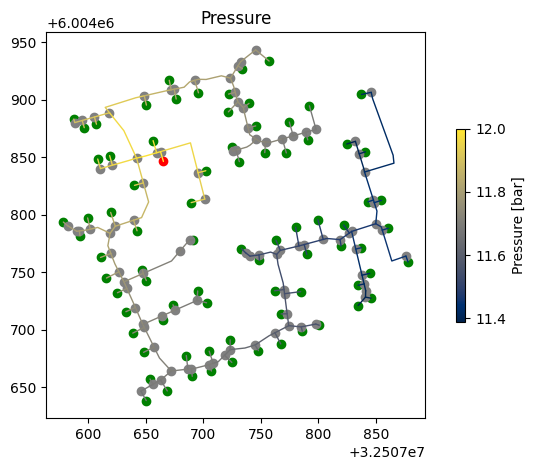

In [56]:
_, ax = plt.subplots()
network.components['consumers'].plot(ax=ax, color='green')
network.components['producers'].plot(ax=ax, color='red')
network.components['forks'].plot(ax=ax, color='grey')
pipes.plot(
    ax=ax,
    column='p_to_bar',
    legend=True, legend_kwds={'label': "Pressure [bar]",
                              'shrink': 0.5},
    cmap='cividis',
    linewidth=1,
    zorder=2
)
plt.title('Pressure')
plt.tight_layout()
plt.show()

plot temperature of pipes' ending nodes

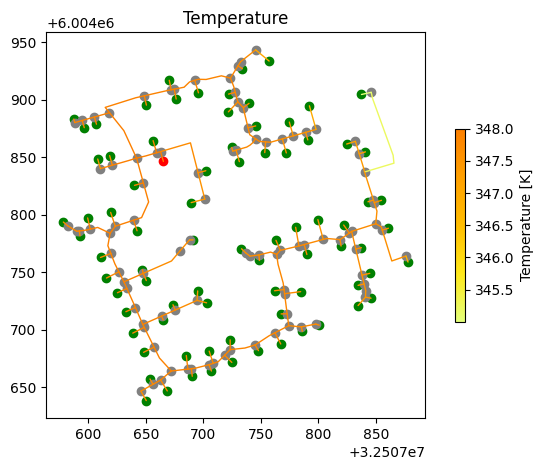

In [57]:
_, ax = plt.subplots()
network.components['consumers'].plot(ax=ax, color='green')
network.components['producers'].plot(ax=ax, color='red')
network.components['forks'].plot(ax=ax, color='grey')
pipes.plot(
    ax=ax,
    column='t_to_k',
    legend=True,
    legend_kwds={'label': "Temperature [K]",
                 'shrink': 0.5},
    cmap='Wistia',
    linewidth=1,
    zorder=2
)
plt.title('Temperature')
plt.tight_layout()
plt.show()